In [1]:
from dotenv import load_dotenv
import os

from langgraph.graph import MessagesState

#### Defining Custom Tools

In [2]:
from langchain_community.tools import tool,Tool

@tool
def multiply(a:int,b:int)->int:
    """ this tool is used to multiply two number"""
    return a*b

In [3]:
@tool
def add(a:int,b:int)->int:
    """This tool is used to add two numbers"""
    return a+b

In [4]:
@tool
def divide(a:int,b:int)->float:
    """This tool is used to calculate division of two numbers"""
    return a/b

In [5]:
from langchain_community.tools import DuckDuckGoSearchResults

web_tool=DuckDuckGoSearchResults()

web_tool.invoke("whats current issue between Trump and Elon Musk?")

"snippet: President Trump and Elon Musk both seem to be moving on after their ugly public feud on Thursday that seemed to tear up their alliance. Trump said Friday he did not want to talk with Musk on the ph…, title: Live updates: Musk, Trump change subject day after nasty feud, link: https://thehill.com/homenews/administration/trump-the-next-100-days/5336541-live-updates-musk-trump-feud/, snippet: Elon Musk wished President Trump well in a post on X late Friday, as a public blowup between the president and the world's richest man showed some signs of cooling off.. When asked about Musk ..., title: Trump-Musk feud simmers, DOJ charges Abrego Garcia, more updates - CBS News, link: https://www.cbsnews.com/live-updates/trump-elon-musk-executive-orders/, snippet: A few months before the war of words between Musk and Trump erupted, the two seemed like an inseparable political force. Musk had spent nearly $200m to elect Trump to a second term in 2024., title: Trump-Musk feud escalates: What 

#### Custom tool to fetch current stock prices

In [35]:
import yfinance as yf
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"
     
    

In [36]:
get_stock_price.invoke("TSLA")

HTTP Error 401: 


"Could not fetch price for ticker 'TSLA'."

In [37]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $198.42.'

### Setting up ReAct Agent

In [9]:
from langchain_groq import ChatGroq
model = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0
)

In [10]:
from langchain_core.messages import SystemMessage

In [11]:
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with using web search and performing arithmetic on a set of inputs."
)

user_query=["tell me what is 2+2"]
[SYSTEM_PROMPT]+user_query

[SystemMessage(content='You are a helpful assistant tasked with using web search and performing arithmetic on a set of inputs.', additional_kwargs={}, response_metadata={}),
 'tell me what is 2+2']

In [12]:
myTool=[web_tool,multiply,add,divide,get_stock_price]
ReAct_Agent=model.bind_tools(myTool)

In [13]:
def function1(state:MessagesState):
    user_query=state["messages"]
    query=[SYSTEM_PROMPT]+user_query
    result=ReAct_Agent.invoke(query)
    return {"messages":[result]}

#### Agent Workflow

In [14]:
from langgraph.graph import StateGraph

workflow1=StateGraph(MessagesState)

In [15]:
workflow1.add_node("ReAct_agent",function1)

In [16]:
from langgraph.graph import START,END
from langgraph.prebuilt import tools_condition
workflow1.add_edge(START,"ReAct_agent")

In [17]:
from langgraph.prebuilt import ToolNode
workflow1.add_node("tools",ToolNode(myTool))

In [18]:

workflow1.add_conditional_edges("ReAct_agent",tools_condition)
workflow1.add_edge("tools","ReAct_agent")

In [19]:
react_graph=workflow1.compile()

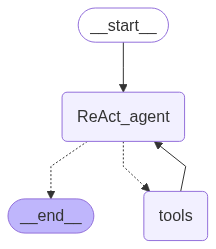

In [20]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [21]:
from langchain_core.messages import HumanMessage, SystemMessage

In [22]:
response=react_graph.invoke({"messages":[HumanMessage(content="What is 2 times of narendramodi's age?")]})

In [23]:
response

{'messages': [HumanMessage(content="What is 2 times of narendramodi's age?", additional_kwargs={}, response_metadata={}, id='f0541958-9491-422e-af84-30c689da97fa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cwexvpm8d', 'function': {'arguments': '{"query":"Narendra Modi age"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 705, 'prompt_tokens': 415, 'total_tokens': 1120, 'completion_time': 2.779170451, 'prompt_time': 0.034181687, 'queue_time': 0.202721641, 'total_time': 2.813352138}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c9ec6731-1d54-4e15-91c1-b58b5fd70bb4-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'Narendra Modi age'}, 'id': 'cwexvpm8d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 415, 'output_tokens': 705, 'total_tokens': 1120}),
  ToolMessage(conten

In [24]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of narendramodi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (cwexvpm8d)
 Call ID: cwexvpm8d
  Args:
    query: Narendra Modi age
================================= Tool Message =================================
Name: duckduckgo_results_json

snippet: Narendra Modi is the 14th prime minister of India. His Hindu nationalist policies and some of his economic reforms have proved controversial to many within and outside India., title: Narendra Modi | Biography, Career, & Facts | Britannica, link: https://www.britannica.com/biography/Narendra-Modi, snippet: List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office on 10 June 2024., title: List of all Prime Ministers of India (1947-2025) | India PM List, link: https://www.jagranjosh.com/general-kn

In [38]:
response=react_graph.invoke({"messages":[HumanMessage(content="what is net worth of Elon Musk as of today and make it half?")]})

In [39]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is net worth of Elon Musk as of today and make it half?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (2vvhah7tk)
 Call ID: 2vvhah7tk
  Args:
    query: Elon Musk net worth today
================================= Tool Message =================================
Name: duckduckgo_results_json

snippet: Elon Musk Net worth: $423 billion Source: Tesla, SpaceX ... car maker's shareholders voted in June in favor of Musk keeping performance-based stock options that would be worth nearly $100 billion today in what a Delaware judge had earlier called "the largest potential compensation opportunity ever observed in public markets," when she ..., title: The Top 10 Richest People In The World (June 2025), link: https://www.forbes.com.au/news/billionaires/the-top-10-richest-people-in-the-world-june-2025/, snippet: What Happened: Musk became ri

In [40]:
ReAct_Agent2=model.bind_tools(myTool)

SYSTEM_PROMPT2 = SystemMessage(
    content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs."
)
def function2(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT2]+user_question
    
    response = ReAct_Agent2.invoke(input_question)
    
    return {
        "messages":[response]
    }

ReAct_Agent.invoke("can you give me a latest stock price of adani greens?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '22hp1e5ht', 'function': {'arguments': '{"ticker":"ADANIGREEN.NS"}', 'name': 'get_stock_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 179, 'prompt_tokens': 397, 'total_tokens': 576, 'completion_time': 0.760110397, 'prompt_time': 0.02564554, 'queue_time': 0.202368969, 'total_time': 0.785755937}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d9cca5ec-8f18-41ac-b515-fada0cf6a6b8-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'ADANIGREEN.NS'}, 'id': '22hp1e5ht', 'type': 'tool_call'}], usage_metadata={'input_tokens': 397, 'output_tokens': 179, 'total_tokens': 576})

In [28]:
res=ReAct_Agent2.invoke("can u tell me current stock price of apple")
res.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'AAPL'},
  'id': 'x7j7r9jzy',
  'type': 'tool_call'}]

In [29]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_decision_step", function2)
workflow.add_node("tools", ToolNode(myTool))
workflow.add_edge(START, "llm_decision_step")
workflow.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
workflow.add_edge("tools", "llm_decision_step")
react_graph2 = workflow.compile()

In [30]:
messages = [HumanMessage(content="can you give me 2 times of current stock price of Apple with the latest news of the Apple.")]
messages = react_graph2.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can you give me 2 times of current stock price of Apple with the latest news of the Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (3r8yttrsd)
 Call ID: 3r8yttrsd
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

Could not fetch price for ticker 'AAPL'.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (x1q8g39fm)
 Call ID: x1q8g39fm
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

Could not fetch price for ticker 'AAPL'.
================================== Ai Message ==================================

I'm sorry, but I can't provide real-time stock prices or the latest news about Apple. However, I can suggest some tools

In [ ]:
messages = [HumanMessage(content="you give me current stock price of Apple  and add it to current stock price of Tesla?.")]
messages = react_graph2.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()